In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



In [13]:
df = pd.read_csv("bank-marketing-campaign-data.csv", sep=';')

df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

features = [col for col in df.columns if col != 'y']
numeric_features = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[features].select_dtypes(include='object').columns.tolist()

if 'was_previously_contacted' in numeric_features:
    numeric_features.remove('was_previously_contacted')
    categorical_features.append('was_previously_contacted')

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nDatos divididos en entrenamiento y prueba:")
print(f"X_train original shape: {X_train.shape}")
print(f"y_train original shape: {y_train.shape}")
print(f"X_test original shape: {X_test.shape}")
print(f"y_test original shape: {y_test.shape}")

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"\nDatos preprocesados y listos para el modelado:")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")



Datos divididos en entrenamiento y prueba:
X_train original shape: (32950, 21)
y_train original shape: (32950,)
X_test original shape: (8238, 21)
y_test original shape: (8238,)

Datos preprocesados y listos para el modelado:
X_train_processed shape: (32950, 65)
X_test_processed shape: (8238, 65)


Confusion Matrix:
[[7145  165]
 [ 524  404]]


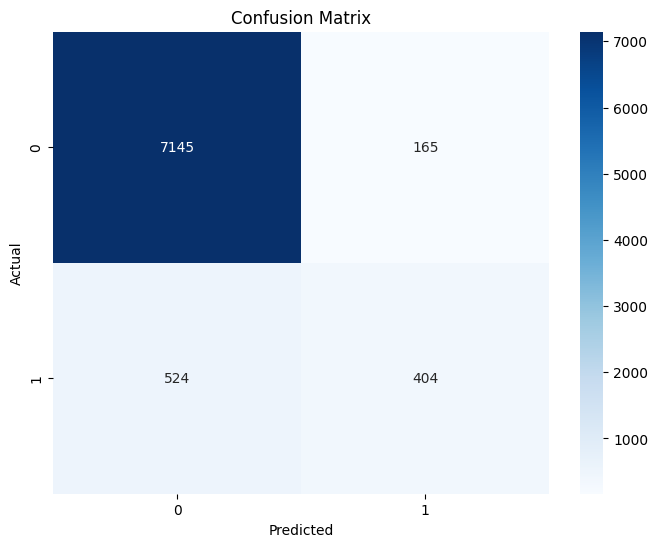

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238

Accuracy Score:
0.9163631949502307
ROC AUC Score:
0.9424132624180387


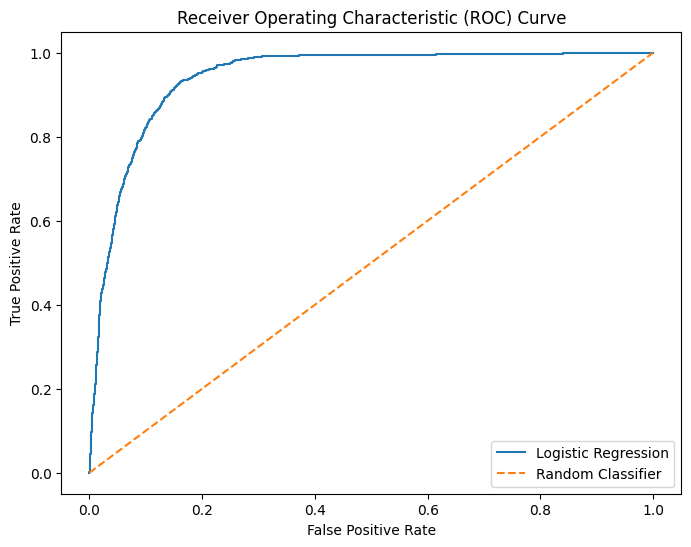

In [14]:
model = LogisticRegression(random_state=42, solver='liblinear')

model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l1'}
Best ROC AUC Score: 0.9352127434463489
Confusion Matrix (Optimized):
[[6319  991]
 [  83  845]]


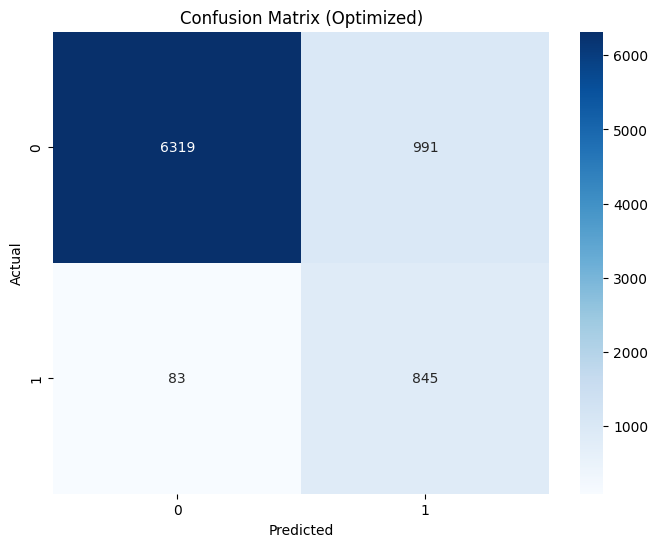

Classification Report (Optimized):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.46      0.91      0.61       928

    accuracy                           0.87      8238
   macro avg       0.72      0.89      0.77      8238
weighted avg       0.93      0.87      0.89      8238

ROC AUC Score (Optimized):
0.9437586973442142
ROC Curve (Optimized):


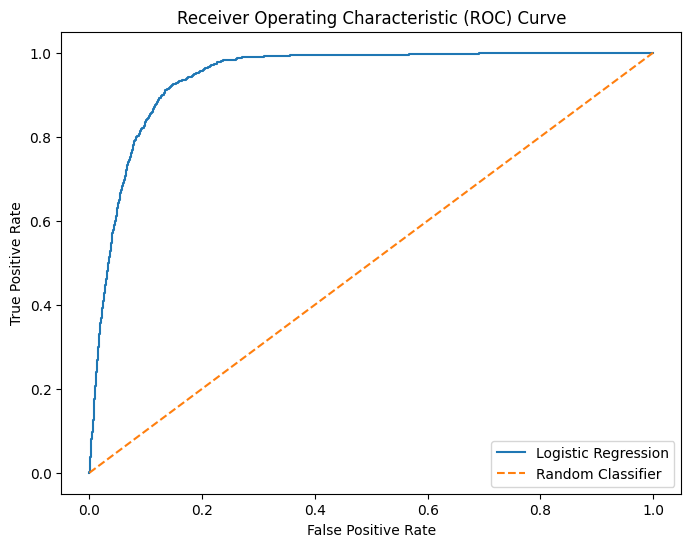

In [15]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])

param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

cm_optimized = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Optimized):")
print(cm_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Optimized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report (Optimized):")
print(classification_report(y_test, y_pred))

print("ROC AUC Score (Optimized):")
print(roc_auc_score(y_test, y_pred_proba))

print("ROC Curve (Optimized):")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


